In [4]:
from spectral import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.constants as constants
import img
import pandas as pd
from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook


In [5]:
def load_flux(fluxname):

    with open(fluxname, 'r') as file:
        data = file.readlines()
        #print(data)
        size = len(data)
        #print(size)
        flux = np.zeros(size)
        wavelengths = np.zeros(size)
        for i in range(size):
            flux[i]=(float(data[i].strip().split(" ,")[1]))
            wavelengths[i]=(float(data[i].strip().split(",")[0]))

    return flux,wavelengths



def load_hdr(filename):
    img = envi.open(filename)
    datafile = img.open_memmap(writeable = False)
    
    return datafile


def load_rdn(filename):
    data = np.load(filename)
    return data


def get_metadata(filename):
    img = envi.open(filename)
    img_data = img.open_memmap(writeable = False)
    metadata = envi.read_envi_header(filename)
    metadata_df = pd.DataFrame.from_dict(metadata, orient='index', columns=['Value'])
    band_names = metadata_df.loc['band names', 'Value']
    bandnames = band_names
    reshape_array = img_data.reshape(-1, img_data.shape[-1])
    df = pd.DataFrame(reshape_array)
    df.columns = band_names
    return df


def get_phase_angle(datafile):
    phase_angle = np.empty(datafile.shape[:-1])
    
    for i in range(len(datafile)):
        for j in range(len(datafile[i])):
            for k in  range(len(datafile[i,j])):
                phase_angle[i,j] = datafile[i,j,4]
    phase_angle = phase_angle.reshape((phase_angle.shape[0], phase_angle.shape[1], 1))
    
    return phase_angle

def get_i(datafile):
    angle_i = np.empty(datafile.shape[:-1])
    
    for i in range(len(datafile)):
        for j in range(len(datafile[i])):
            for k in  range(len(datafile[i,j])):
                angle_i[i,j] = datafile[i,j,1]
    angle_i = angle_i.reshape((angle_i.shape[0], angle_i.shape[1], 1))
    
    return angle_i

def get_e(datafile):
    angle_e = np.empty(datafile.shape[:-1])
    
    for i in range(len(datafile)):
        for j in range(len(datafile[i])):
            for k in  range(len(datafile[i,j])):
                angle_e[i,j] = datafile[i,j,3]
    angle_e = angle_e.reshape((angle_e.shape[0], angle_e.shape[1], 1))
    
    return angle_e


def flux_correction(data, flux, band):
    corrected_data = np.zeros((data.shape[0],data.shape[1], 1))
    for i in range(len(data)):
        for j in range(len(data[i])):
            corrected_data[i,j,0] = data[i,j,band]/flux[band]
    corrected_data = corrected_data.reshape(1,-1)
    corrected_data = np.squeeze(corrected_data)  
    return corrected_data


def Data_binning(correcteddata, phase_angle, phase_cosi, bin_size):
   
    phase_angle_ = phase_angle.reshape(1,-1)
    phase_angle_ = np.squeeze(phase_angle_)
   
    phase_cosi1 = phase_cosi.reshape(1,-1)
    phase_cosi1 = np.squeeze(phase_cosi1)
   
    # Define phase angle bin ra# Minimum and maximum phase angle values
    min_angle = np.min(phase_angle)
    max_angle = np.max(phase_angle)
    num_bins = bin_size

    # Calculate the bin width
    bin_width = (max_angle - min_angle) / num_bins

    # Create bin ranges
    bin_ranges = [(min_angle + i * bin_width, min_angle + (i + 1) * bin_width) for i in range(num_bins)]

    binned_reflectance = np.zeros(len(bin_ranges))
    binned_cosi = np.zeros(len(bin_ranges))
   
    bin_counts = np.zeros(len(bin_ranges), dtype=int)

    # Bin the reflectance data based on phase angles
    for i, bin_range in enumerate(bin_ranges):
        lower_bound, upper_bound = bin_range
        bin_reflectance = []
        bin_cosi = []
   
        # Loop through phase angles and reflectance values
        for angle1, angle2, reflectance in zip(phase_angle_,phase_cosi1, correcteddata):
            if lower_bound <= angle1 < upper_bound:
                bin_reflectance.append(reflectance)
                bin_cosi.append(angle2)
   
        # Calculate average reflectance and count
        if bin_reflectance:
            binned_reflectance[i] = np.mean(bin_reflectance)
            bin_counts[i] = len(bin_reflectance)
       
        if bin_cosi:
            binned_cosi[i] = np.mean(bin_cosi)
            bin_counts[i] = len(bin_cosi)
   
    binned_phase_angle = []
    for bin_tuple in bin_ranges:
        average = np.mean(bin_tuple)
        binned_phase_angle.append(average)
 
    return binned_phase_angle,binned_cosi, binned_reflectance

def splot_binned_data_wphase(binned_angle,binned_reflectance, band):
    plt.scatter(binned_angle,binned_reflectance,marker='s', s=6)
    plt.xlabel('Phase angle(binned and averaged)')
    plt.ylabel('Reflectance(Averaged/binned)')
    plt.title(f'Spectrum for {band}th band') 
    
def binning(bin,i_data,e_data, phaseangle_data, corr_data):
    
    rnd_i = np.round(i_data, decimals=0).astype(int)
    rnd_e = np.round(e_data, decimals=0).astype(int)
    rnd_phase = np.round(phaseangle_data, decimals=0).astype(int)
    
    for j in tqdm_notebook(range(len(bin))):
        # Find indices where conditions are met
        indices = np.where((rnd_phase == bin[j, 0]) & (rnd_i == bin[j, 1]) & (rnd_e == bin[j, 2]))[0]

        # Sum up the corresponding values from corr_data
        summed_values = corr_data[indices].sum()

        # Update bin with summed values and count of data points
        bin[j, 3] = bin[j,3] + summed_values
        bin[j, 4] = bin[j,4] + len(indices)
        
    return bin

In [90]:
fluxdatafile = 'Data/m3_solarflux.txt'
imgdatafile = 'Data\OBS DATA\m3g20081129t052459_v03_obs.hdr'
rdndatafile = 'Data\RDN data\corr_i_m3g20081129t052459_v03_rdn.npy'
band = 50
binsize = 100
flux, wavelengths = load_flux(fluxdatafile)
img_data = load_hdr(imgdatafile)
rdn_data = load_rdn(rdndatafile)
phaseangle_data = get_phase_angle(img_data)
i_data = get_i(img_data)
e_data = get_e(img_data)
corr_data = flux_correction(rdn_data, flux,band)

KeyboardInterrupt: 

In [6]:
i_data = i_data.reshape(1,-1)
i_data = np.squeeze(i_data)
e_data = e_data.reshape(1,-1)
e_data = np.squeeze(e_data)
phaseangle_data = phaseangle_data.reshape(1,-1)
phaseangle_data = np.squeeze(phaseangle_data)

NameError: name 'i_data' is not defined

In [ ]:
            
rnd_i = np.round(i_data, decimals=0).astype(int)
rnd_e = np.round(e_data, decimals=0).astype(int)
rnd_phase = np.round(phaseangle_data, decimals=0).astype(int)





In [7]:
bin = []
for a in range(10,100):
    for i in range(10,100):
        for e in range(10,100):
            arr = [a,i,e,0,0]
            bin.append(arr)
bin = np.array(bin)
#np.set_printoptions(threshold=np.inf)


In [ ]:
save_path = 'bin_1_img.txt'
np.savetxt(save_path,bin)

In [ ]:
y = np.array([])
for i in range(len(bin)):
    y = np.append(y,bin[i,3]/bin[i,4])

C:\Users\soham\AppData\Local\Temp\ipykernel_3836\538731525.py:3: RuntimeWarning: invalid value encountered in scalar divide
  y = np.append(y,bin[i,3]/bin[i,4])


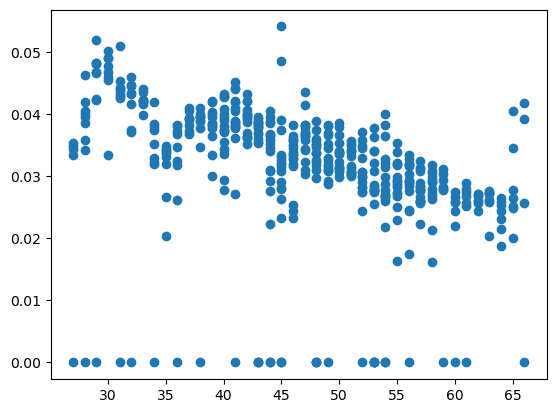

In [ ]:
plt.scatter(bin[:,0], y)

2nd Image

In [ ]:
fluxdatafile = 'Data/m3_solarflux.txt'
imgdatafile = 'Data\OBS DATA\m3g20081129t171431_v03_obs.hdr'
rdndatafile = 'Data\RDN data\corr_i_m3g20081129t171431_v03_rdn.npy'
band = 50
binsize = 100
flux, wavelengths = load_flux(fluxdatafile)
img_data = load_hdr(imgdatafile)
rdn_data = load_rdn(rdndatafile)
phaseangle_data = get_phase_angle(img_data)
i_data = get_i(img_data)
e_data = get_e(img_data)
corr_data = flux_correction(rdn_data, flux,band)

In [ ]:
bin = binning(bin,i_data,e_data,phaseangle_data,corr_data)
y = np.array([])
for i in range(len(bin)):
    y = np.append(y,bin[i,3]/bin[i,4])
    
plt.scatter(bin[:,0], y)

In [ ]:
save_path = 'bin_data/bin_2_img.txt'
np.savetxt(save_path,bin)

3rd image

In [3]:
bin = np.loadtxt('bin_data/bin_2_img.txt')

In [7]:
fluxdatafile = 'Data/m3_solarflux.txt'
imgdatafile = 'Data\OBS DATA\m3g20081129t171509_v03_obs.hdr'
rdndatafile = 'Data\RDN data\corr_i_m3g20081129t171509_v03_rdn.npy'
band = 50
binsize = 100
flux, wavelengths = load_flux(fluxdatafile)
img_data = load_hdr(imgdatafile)
rdn_data = load_rdn(rdndatafile)
phaseangle_data = get_phase_angle(img_data)
i_data = get_i(img_data)
e_data = get_e(img_data)
corr_data = flux_correction(rdn_data, flux,band)

In [8]:
i_data = i_data.reshape(1,-1)
i_data = np.squeeze(i_data)
e_data = e_data.reshape(1,-1)
e_data = np.squeeze(e_data)
phaseangle_data = phaseangle_data.reshape(1,-1)
phaseangle_data = np.squeeze(phaseangle_data)

In [9]:
bin = binning(bin,i_data,e_data,phaseangle_data,corr_data)
y = np.array([])
for i in range(len(bin)):
    y = np.append(y,bin[i,3]/bin[i,4])
    
plt.scatter(bin[:,0], y)

  0%|          | 0/729000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [177]:
BATH_SIZE = 32
CHECK = np.concatenate([rnd_phase[:,None]]*BATH_SIZE,axis = -1)
BIN = np.concatenate([bin[BATH_SIZE*4303:BATH_SIZE*4304,0][None,:]]*rnd_phase.shape[0],axis =0)
IDX = CHECK == BIN
lIDX = np.where(IDX)[1][:-1]
rIDX = np.where(IDX)[1][1:]
dd
IDX_ = np.where(IDX)[0]
val = np.where(IDX)[1]

cIDX = np.where(IDX)[1]
cIDX[1:] = cIDX[1:] - lIDX
sIDX = np.where(cIDX < 0)[0]
sIDX=np.array([0]+sIDX.tolist()) 



In [178]:
list_ = [val[sIDX[i]:sIDX[i+1]] for i in range(sIDX.shape[0]-1)]

In [179]:
list_

[array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64),

In [139]:
i

99

In [132]:
val


array([  284,   284,   284, ..., 32527, 32527, 32527], dtype=int64)

In [74]:
CHECK.shape

(76304, 32)

In [105]:
sIDX

(array([   28,    56,    84, ..., 30688, 30716, 30744], dtype=int64),)

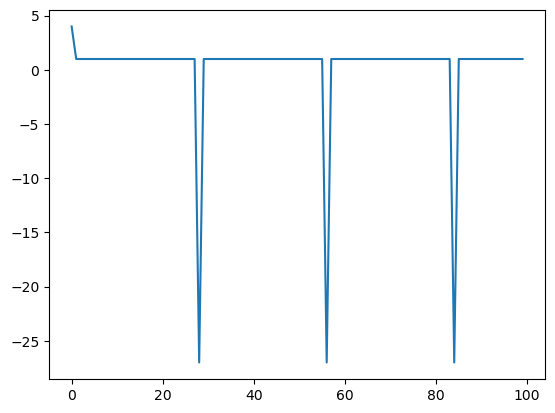

In [103]:
plt.plot(cIDX[:100])

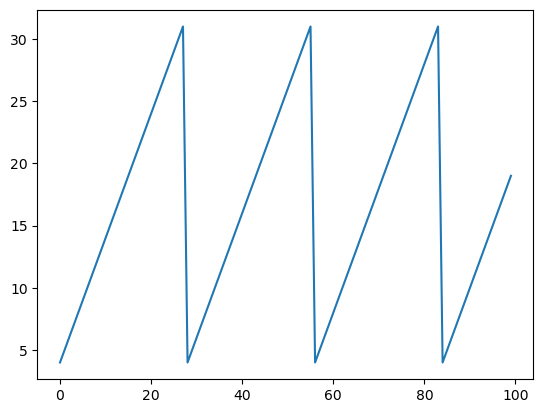

In [98]:
plt.plot(np.where(IDX)[1][:100])

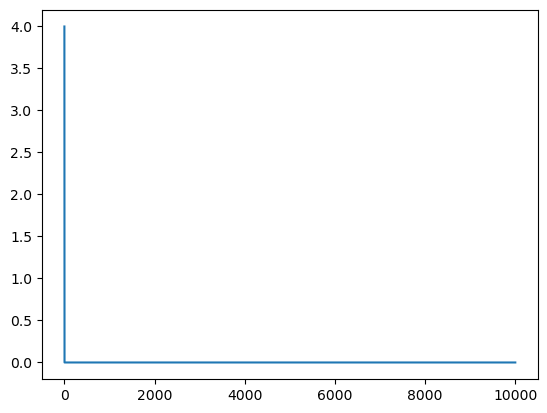

In [88]:
np.where(IDX)[0]

array([  284,   284,   284, ..., 32527, 32527, 32527], dtype=int64)

In [45]:
rnd_phase

array([40, 40, 40, ..., 28, 28, 28])

In [ ]:
bim

6066

In [61]:
bin[j][0]

27

In [51]:
for j in tqdm(range(bin.shape[0])):
    if np.where(rnd_phase == bin[j,0])[0].shape[0] > 0:
        print(j)
        break
    # print(np.where(rnd_phase == bin[j,0]))

  0%|          | 0/729000 [00:00<?, ?it/s]

137700


In [32]:
bin[:BATH_SIZE,0].shape

(32,)

In [40]:
np.where(IDX)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
phase_tensor = np.vstack(rnd_phase)

In [ ]:
(rnd_phase == bin[69, 0]).shape

(1713344,)

In [ ]:
((rnd_phase == bin[j, 0]) & (rnd_i == bin[j, 1]) & (rnd_e == bin[j, 2])).shape

(5636, 304, 1)

In [ ]:
indices = np.where()[0]

In [ ]:
bin = binning(bin,i_data,e_data,phaseangle_data,corr_data)

  0%|          | 0/729000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
y = np.array([])
for i in range(len(bin)):
    y = np.append(y,bin[i,3]/bin[i,4])
    
plt.scatter(bin[:,0], y)

In [ ]:
def spectral_phase_angle_analysis(fluxdatafile, imgdatafile, rdndatafile, band, binsize):
    flux, wavelengths = load_flux(fluxdatafile)
    img_data = load_hdr(imgdatafile)
    rdn_data = load_rdn(rdndatafile)
    phaseangle_data = get_phase_angle(img_data)
    i_data = get_i(img_data)
    corr_data = flux_correction(rdn_data, flux,band)
    binned_phase_angle, binned_cosi, binned_reflect = Data_binning(corr_data, phaseangle_data, i_data, binsize)
    splot_binned_data_wphase(binned_phase_angle,binned_reflect,band)
    return binned_phase_angle, binned_cosi, binned_reflect

In [ ]:
get_metadata('Data\OBS DATA\m3g20090623t135841_v03_obs.hdr')

,To-Sun Azimuth (deg),To-Sun Zenith (deg),To-M3 Azimuth (deg),To-M3 Zenith (deg),Phase (deg),To-Sun Path Length (au-1.014063870329),To-M3 Path Length (m),Facet Slope (deg),Facet Aspect (deg),Facet Cos(i) (unitless)
0,23.200544,17.450945,107.513466,10.868845,19.530325,-0.000003,195263.093750,3.731241,105.788330,0.954470
1,23.171261,17.448137,107.614670,10.783389,19.511438,-0.000003,195229.468750,3.590223,103.411537,0.955299
2,23.141953,17.445328,107.717735,10.697972,19.492880,-0.000003,195194.812500,3.459884,100.502304,0.956224
3,23.112627,17.442520,107.822723,10.612598,19.474649,-0.000003,195159.406250,3.370382,96.462502,0.957417
4,23.083288,17.439711,107.929665,10.527269,19.456749,-0.000003,195123.484375,3.823589,88.235794,0.960307
...,...,...,...,...,...,...,...,...,...,...
4695579,232.567657,92.446594,125.311440,15.189968,96.825905,0.000005,193741.859375,4.577205,264.389618,0.025194
4695580,232.709183,92.444832,125.489723,15.277375,96.839073,0.000005,193823.906250,5.259771,265.465485,0.034546
4695581,232.848648,92.443085,125.665367,15.364702,96.852272,0.000005,193895.187500,5.820592,285.367432,0.019247
4695582,232.991196,92.441269,125.843513,15.452260,96.865486,0.000005,193991.046875,8.517990,285.568207,0.047805


# data analysis of 21 images

In [ ]:
import os
import glob

# Path to the folders containing the files
obsdata = 'Data\OBS DATA'
rdndata = 'Data\RDN data'
phaseangle = np.empty((1,0))
cosi = np.empty((1,0))
refl = np.empty((1,0))

# Get the list of files in each folder
obs_files_ = os.listdir(obsdata)
rdn_files = os.listdir(rdndata)
obs_files = [file for file in obs_files_ if file.endswith(".hdr")]
# Iterate over the files in both folders simultaneously
for file1, file2 in zip(obs_files, rdn_files):
    # Construct the full paths to the files
    obs_path = os.path.join(obsdata, file1)
    rdn_path = os.path.join(rdndata, file2)

    flux_datafile = 'Data/m3_solarflux.txt'
    img_datafile = obs_path
    rdn_datafile = rdn_path
    band = 60
    binsize = 100
    phaseangle_, cosi_, reflect =  spectral_phase_angle_analysis(flux_datafile, img_datafile, rdn_datafile, band, binsize)
    phaseangle = np.append(phaseangle, phaseangle_)
    cosi = np.append(cosi, cosi_)
    refl = np.append(refl, reflect)
    plt.show()
    

    

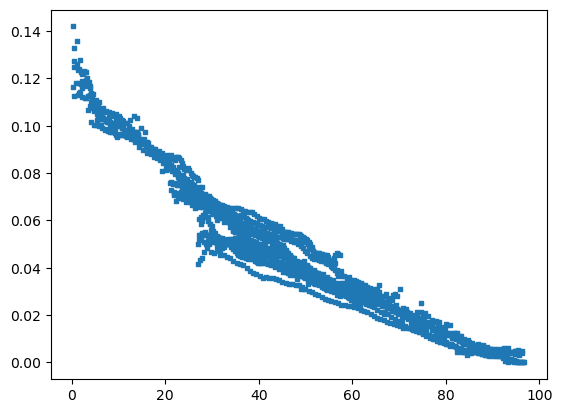

In [ ]:
plt.scatter(phaseangle,refl, marker='s', s=6)


# Data Fitting

In [ ]:

# Sort the indices of x
sorted_indices = np.argsort(phaseangle)

# Rearrange x and y based on sorted indices
sorted_phase = phaseangle[sorted_indices]
sorted_refl = refl[sorted_indices]
sorted_cosi = cosi[sorted_indices]


Sorted x: [1 2 3 4 5]
Sorted y: [10 20 30 40 50]


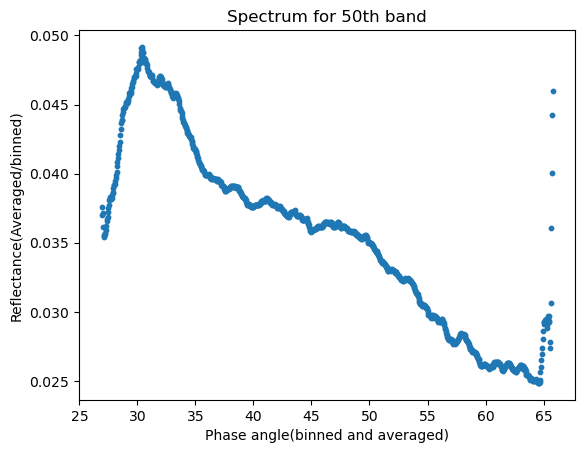

In [ ]:
flux_datafile = 'Data/m3_solarflux.txt'
img_datafile = 'Data\OBS DATA\drive-download-20240321T161103Z-001\m3g20081129t052459_v03_obs.hdr'
rdn_datafile = 'Data\RDN data\corr_i_m3g20081129t052459_v03_rdn.npy'
band = 50
binsize = 100
a1, r1 = spectral_phase_angle_analysis(flux_datafile, img_datafile, rdn_datafile, 50, 100)